Identifying Fraud from Enron Email
==================

1. Understanding the Dataset
--------------------------

###  1.1 Data exploration

In [1]:
import cPickle
enron_data = cPickle.load(open("final_project_dataset.pkl", 'r'))

poi_count = 0
non_poi_count = 0
for p in enron_data.values():
    if p["poi"]:
        poi_count += 1
    else:
        non_poi_count += 1
        
# Get an example (the first) data point.
eg = enron_data.itervalues().next()

print "Number of data points:", len(enron_data)
print "Number of POIs:", poi_count
print "Number of non-POIs:", non_poi_count
print "Number of features:", len(eg)

def missing_count(enron_data, feature):
    """Return number of missing values of `feature`."""
    count = 0
    for p in enron_data:
        if enron_data[p][feature] == "NaN":
            count += 1
    return count

missing_counts = [(f, missing_count(enron_data, f)) for f in eg]
print "Number of missing features:"
for f,c in sorted(missing_counts, key = lambda x: x[1], reverse = True):
    print "  ", f, ":", c

Number of data points: 146
Number of POIs: 18
Number of non-POIs: 128
Number of features: 21
Number of missing features:
   loan_advances : 142
   director_fees : 129
   restricted_stock_deferred : 128
   deferral_payments : 107
   deferred_income : 97
   long_term_incentive : 80
   bonus : 64
   to_messages : 60
   shared_receipt_with_poi : 60
   from_messages : 60
   from_this_person_to_poi : 60
   from_poi_to_this_person : 60
   other : 53
   salary : 51
   expenses : 51
   exercised_stock_options : 44
   restricted_stock : 36
   email_address : 35
   total_payments : 21
   total_stock_value : 20
   poi : 0


From the results above, we see that there are 146 total number of data points, 18 of which are POI and the rest 128 are non-POI. (Note that there is one outlier data point named `TOTAL` which is actually not a person, as will be explained in Section 1.2).

There are 21 features provided by the `final_project_dataset.pkl`. Among those features, the `loan_advances`, `director_fees`, `restricted_stock_deferred`, `deferral_payments`, `deferred_income` and `long_term_incentive` have more than half of the data points with missing values. (We will also create new features based on email text, as described in Section 2.1).

### 1.2 Outlier investigation

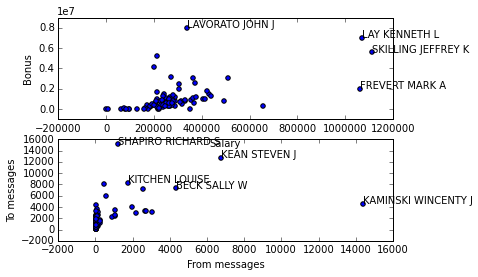

In [2]:
%matplotlib inline
import sys
sys.path.append("../tools")
from feature_format import featureFormat, targetFeatureSplit

enron_data = cPickle.load(open("final_project_dataset.pkl", 'r'))
del enron_data["TOTAL"]

features = ["salary", "bonus"]
data = featureFormat(enron_data, features)
plt.subplot(211)
plt.scatter(data[:,0], data[:,1])
for p in enron_data:
    salary = enron_data[p]["salary"]
    bonus = enron_data[p]["bonus"]
    if salary == "NaN" or bonus == "NaN":
        continue
    if (salary > np.percentile(data[:,0], 97) or
        bonus > np.percentile(data[:,1], 97)):
        plt.text(salary, bonus, p)
plt.xlabel("Salary")
plt.ylabel("Bonus")

features = ["from_messages", "to_messages"]
data = featureFormat(enron_data, features)
plt.subplot(212)
plt.scatter(data[:,0], data[:,1])
for p in enron_data:
    from_messages = enron_data[p]["from_messages"]
    to_messages = enron_data[p]["to_messages"]
    if from_messages == "NaN" or to_messages == "NaN":
        continue
    if (from_messages > np.percentile(data[:,0], 97) or
        to_messages > np.percentile(data[:,1], 97)):
        plt.text(from_messages, to_messages, p)
plt.xlabel("From messages")
plt.ylabel("To messages")

We found a data point named `TOTAL`, which is not an individual person but the summary of all other persons in the dataset. It is clearly an outlier for our identifying POI purpose, and therefore we directly remove it from the dataset.

We also try to detect the outliers for some features. In the `bonus` v.s. `salary` plot, we see that there are 4 outliers: `LAY KENNETH L`, `SKILLING JEFFREY K` and `FREVERT MARK A` made salary over \$1 million, and `LAVORATO JOHN J` made a bonus \$8 million.

Similary, there are several outliers for the number of emails sent and received, notably `KAMINSKI WINCENTY J` and `SHAPIRO RICHARD S` who sent and received more than 14,000 emails respectively.

2. Feature Selection
-------------------

### 2.1 Create new features

We will create two new features that characterize the emails sent and received by each person, respectively.

We first collect all the emails sent and received by each person and put them in a single text file for further process (two text files per person). This step takes a long time because there are a large number of text files to go through. Once they are collected and aggregated, reading the aggregated text file will be much faster.

In [3]:
import os
import cPickle
import sys

sys.path.append( "../tools" )
from parse_out_email_text import parseOutText

enron_data = cPickle.load(open("final_project_dataset.pkl", 'r'))
del enron_data["TOTAL"]

# Create two folders to store each person's email.
if not os.path.isdir("from_emails"):
    os.mkdir("from_emails")
if not os.path.isdir("to_emails"):
    os.mkdir("to_emails")
    
def collect_emails(fin, fout):
    """Collect all the emails from text file `fin`,
    and put them together in the output text file `fout`."""
    if not os.path.exists(fin):
        return
    with open(fin, 'r') as fi:
        with open(fout, 'w') as fo:
            for e in fi:
                # The email filename is `enron_mail_20110402/maildir/xxxx.\n` in `fin`,
                # we need to convert it to `../maildir/xxxx.`
                email = ".." + e[len("enron_mail_20110402"):-1]
                fo.write(parseOutText(open(email)))

for p in enron_data:
    email_address = enron_data[p]["email_address"]
    if email_address == "NaN":
        continue
    
    collect_emails("emails_by_address/from_" + email_address + ".txt",
                   "from_emails/" + email_address + ".txt")
    collect_emails("emails_by_address/to_" + email_address + ".txt",
                   "to_emails/" + email_address + ".txt")
        

Now we can load the text files in to memory for further processing.

In [4]:
import cPickle
import os

enron_data = cPickle.load(open("final_project_dataset.pkl", 'r'))

from_emails = []
from_emails_key = []
to_emails = []
to_emails_key =  []

for p in enron_data:
    email_address = enron_data[p]["email_address"]
    if email_address == "NaN":
        continue

    from_email = "from_emails/" + email_address + ".txt"
    if os.path.exists(from_email):
        with open(from_email, 'r') as f:
            from_emails.append(" ".join(f.readlines()))
            from_emails_key.append(p)
    
    to_email = "to_emails/" + email_address + ".txt"
    if os.path.exists(to_email):
        with open(to_email, 'r') as f:
            to_emails.append(" ".join(f.readlines()))
            to_emails_key.append(p)

We vectorize text data using tf-idf.

In [5]:
import cPickle
from sklearn.feature_extraction.text import TfidfVectorizer

from_vectorizer = TfidfVectorizer(stop_words = "english")
from_vectorizer.fit(from_emails)
from_tfidf = from_vectorizer.transform(from_emails)
cPickle.dump((from_tfidf, from_emails_key), open("from_tfidf.pkl", 'w'))

to_vectorizer = TfidfVectorizer(stop_words = "english")
to_vectorizer.fit(from_emails)
to_tfidf = from_vectorizer.transform(from_emails)
cPickle.dump((to_tfidf, to_emails_key), open("to_tfidf.pkl", 'w'))

The tf-idf vector contains tens of thousands of entries, which is cumbersome to operate on and to combine with other features. Therefore we perform a dimensionality reduction using PCA, keeping the 10 most important components of each tf-idf vector and use them as our new features.

In [6]:
from sklearn.decomposition import PCA

from_tfidf_pca = PCA(n_components = 10).fit_transform(from_tfidf.todense())
to_tfidf_pca = PCA(n_components = 10).fit_transform(to_tfidf.todense())

cPickle.dump((from_tfidf_pca, from_emails_key), open("from_tfidf_pca.pkl", 'w'))
cPickle.dump((to_tfidf_pca, to_emails_key), open("to_tfidf_pca.pkl", 'w'))

### 2.2 Intelligently select features

We perform feature selection by hand: adding one feature at a time and check whether the added feature improve the performance of a baseline classifier. The baseline classifier we used is naive Bayes classifier with Gaussian distribution, and the performance measure we use is F1 score. The selection procedure is documented as below:

  1. Use feature `salary`, F1 score: 0.17718
  2. Adding features `from_tfidf_pca` and `to_tfidf_pca`, F1 score: 0.23325
  3. Adding feature `bonus`, F1 score: 0.25721
  4. Adding feature `total_stock_value`, F1 score: 0.32506
  5. Adding feature `total_payments`, F1 score: 0.27499 [score decreased, dropping this feature]
  6. Adding feature `restricted_stock`, F1 score: 0.33496
  7. Adding feature `exercised_stock_options`, F1 score: 0.36112
  8. Adding feature `expenses`, F1 score: 0.36841
  9. Adding feature `other`, F1 score: 0.28425 [score decreased, dropping this feature]

Therefore, our finally selected features are {`salary`, `from_tfidf_pca`, `to_tfidf_pca`, `bonus`, `total_stock_value`, `restricted_stock`, `exercised_stock_options`, `expenses`}.

### 2.3 Properly scale features

We use decision-tree based algorithms in the following section (or ensemble algorithms with decision tree as the base estimator), which is generally not vulnerable to features being of different ranges, and therefore they do not require an explicit feature scaling.

3. Choose and Tune an Algorithm
-----------------------------

### 3.1 Pick an algorithm

We tried two different classification algorithms: (1) AdaBoost classifier with decision tree as base estimator, and (2) the decision tree classifier itself. We try several different set of parameters and pick the best ones by hand (this is for comparison between the two algorithms only, the parameter fine tuning is described in the next section), and found that the decision tree classifier works better than AdaBoost in this dataset.

More precisely, the AdaBoost classifier (with best hand-picked parameters) we used is the following, with precision 0.26453 and recall 0.30950.

    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1),
                           algorithm = "SAMME",
                           n_estimators = 40,
                           learning_rate = 0.5,
                           random_state = 13)

The decision tree classifier (with best hand-picked parameters) we used is the following, with precision 0.32392 and recall 0.32100.

    clf = DecisionTreeClassifier(criterion="gini",
                                 max_depth = 50,
                                 min_samples_split=2,
                                 random_state = 73)

        

### 3.2 Tune the algorithm

We fine-tune the decision tree classifier using a grid search cross validation. In other words, we wrap the classifier with `GridSearchCV`, so that best parameters will be automatically chosen through cross validation. We tuned two parameters for decision tree: 
* `max_depth`: the maximum depth of the tree. We tried 10, 20 and 50.
* `max_features`: The number of features to consider when looking for the best split. We tried `sqrt`, `log2` and `None` (which uses all the features).


More precisely, the classifier we use in final analysis is:

    params = {"max_depth": (10, 20, 50),
              "max_features": ("sqrt", "log2", None)}
    clf = GridSearchCV(DecisionTreeClassifier(random_state=73), params,
                       scoring = "f1")

4. Validation and Evaluation
--------------------------

### 4.1 Usage of evaluation metrics

We use precision-recall as evaluation metrics.

Precision is defined as the fraction of retrieved instances that are relevant, or in our case, amoungst all predicted POIs by the classifier, what percentage are really POIs.

Recall is defined as the fraction of relavent instances that are retrieved, or in our case, amoungst all real POIs, what percentage are predicted by the classifier.

I found the following figure from Wikipedia (source https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg) particularly helpful to understand these two terms.
![precision-recall](Precisionrecall.svg)

### 4.2 Validation strategy

In the evaluation stage, we use the `StratifiedShuffleSplit` cross validation strategy as implemented in `tester.py`. More specifically, the data is split into training and test set using `StratifiedKFold` method, which preserves the percentage of samples for POI and non-POIs in each fold. During the split, 10% of the data is used for set. The evaluation is performed for 1000 iterations of re-shuffling and splitting, and the aggregated results over all iterations are reported at the end.

Furthermore, the (super-)parameters of the model are also chosen using cross validation implemented in `GridSearchCV`, which splits the input data to the classifier into training and validation set, use the training set to fit and validation set to decide which super-parameter achieves the best results.

### 4.3 Algorithm performance

The final algorithm performance is:
* Precision: 0.36066
* Recall: 0.35200